<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PRA
</p>
<p style="margin: 0; text-align:right;">2021-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Práctica final

En esta práctica implementaremos redes neuronales recurrentes para generar música.

**Importante: La entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio. Para exportar el notebook a html puede hacerse desde el menú File $\to$ Download as $\to$ HTML.**

# Sección 1. Análisis Exploratorio de los datos [1.5 pts]

## 1.1 Importación de módulos y paquetes necesarios

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# añade el path a tu directorio
%cd /content/drive/My Drive/deep_learning/PRA/dataset/practica_DL_UOC_2022

/content/drive/.shortcut-targets-by-id/1Vjfb3pDcauYf3YVh0rXifaeHsOVhTC9Q/deep_learning/PRA/dataset/practica_DL_UOC_2022


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pickle
import os
import sys
from collections import Counter
import collections
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


## 1.2 Carga de imágenes en dataset

In [4]:
import cv2

In [5]:
from inspect import classify_class_attrs
ROOT_PATH = '/content/drive/My Drive/deep_learning/PRA/dataset/practica_DL_UOC_2022'

def load_data(path: str):
  """
  """
  data = []
  for folder in os.listdir(path):
    print('Processing folder:' + folder)
    data.append(load_models(folder))
  return data

def load_models(folder):
  train = []
  test = []
  valid = []
  train = load_images(folder, 'train')
  test = load_images(folder, 'test')
  valid = load_images(folder, 'valid')

  return np.asarray(train, dtype=object), np.asarray(test, dtype=object), np.asarray(valid, dtype=object)

def load_images(folder, model):
  data = []
  path = os.path.join(folder, model)
  for classifier in os.listdir(path):
    print('Processing class:' + classifier)
    path = os.path.join(folder, model, classifier)
    for img in os.listdir(path):
      #print('Processing image:' + img)
      img_absolute_path = os.path.join(path, img)
      image_data_temp = cv2.imread(img_absolute_path)
      data.append([image_data_temp, classifier])
  return data


train, test, valid = load_models('Fold0')

Processing class:normal
Processing class:abnormal
Processing class:normal
Processing class:abnormal
Processing class:abnormal
Processing class:normal


In [6]:
train.shape, test.shape, valid.shape 

((1379, 2), (174, 2), (154, 2))

In [7]:
train[0][0].shape, test[0][0].shape, valid[0][0].shape 

((224, 224, 3), (224, 224, 3), (224, 224, 3))

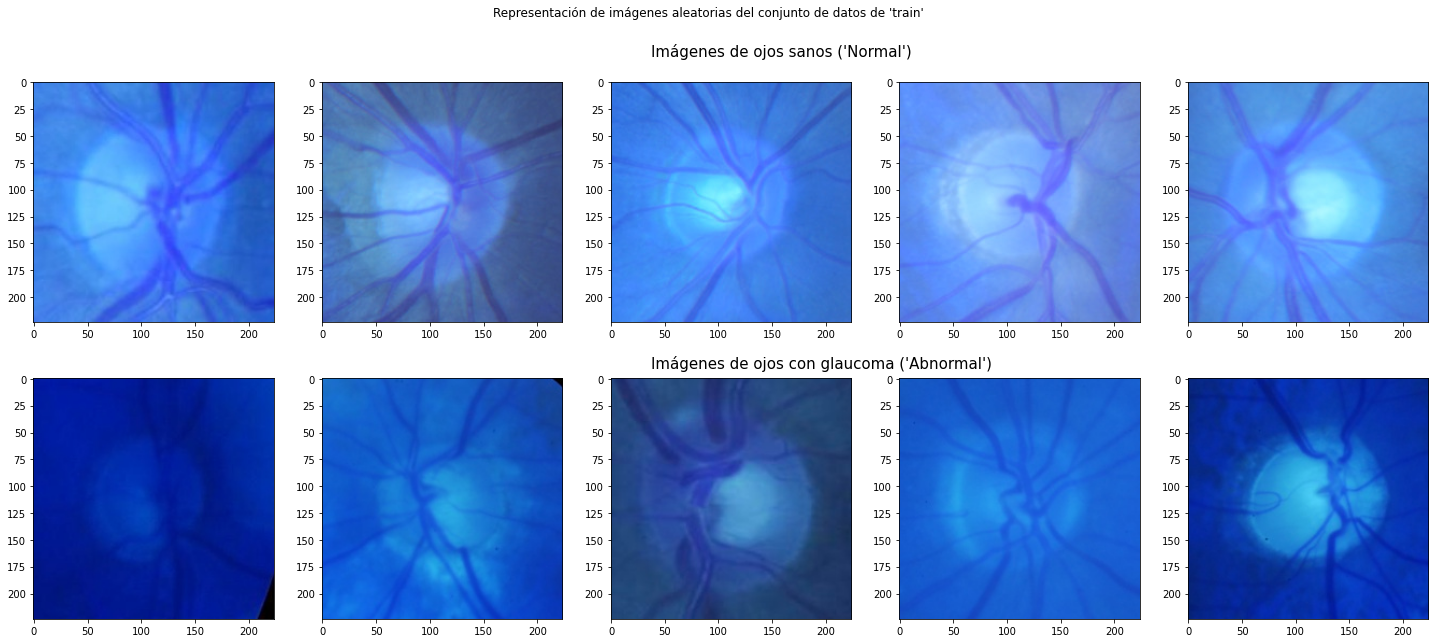

In [8]:
# Adjust proper figsize for scaling up the images
f, big_axes = plt.subplots(2,5, figsize=(25,10))

normal = train[np.where(train[:, 1] == 'normal')]
n = 0
for j in range(0,5):
  big_axes[0,j].imshow(normal[n][0])
  n = n + 1

abnormal = train[np.where(train[:, 1] == 'abnormal')]
n = 0
for j in range(0,5):
  big_axes[1,j].imshow(abnormal[n][0])
  n = n + 1

plt.text(-500, -300, 'Imágenes de ojos sanos (\'Normal\')', fontsize=15)
plt.text(-500, -10, 'Imágenes de ojos con glaucoma (\'Abnormal\')', fontsize=15)
plt.suptitle('Representación de imágenes aleatorias del conjunto de datos de \'train\'')

plt.show()


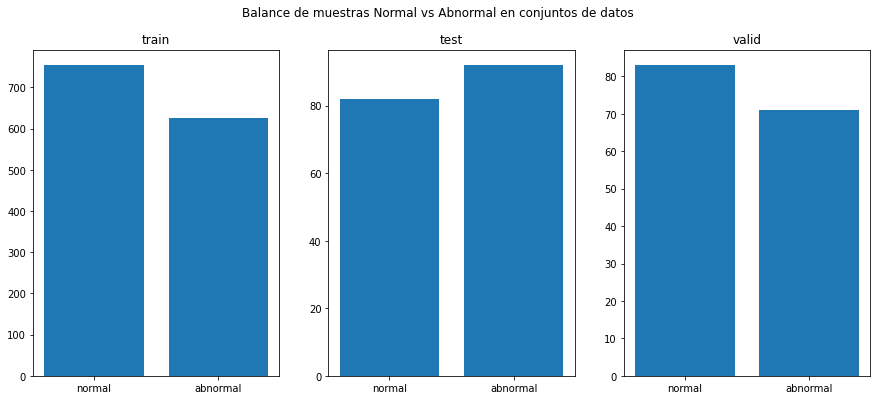

In [9]:
f, axarr = plt.subplots(1,3, figsize=(15,6))

classes = ['normal', 'abnormal']
counts = [normal.shape[0], abnormal.shape[0]]
axarr[0].bar(classes, counts)
axarr[0].set_title('train')

normal = test[np.where(test[:, 1] == 'normal')]
abnormal = test[np.where(test[:, 1] == 'abnormal')]
counts = [normal.shape[0], abnormal.shape[0]]
axarr[1].bar(classes, counts)
axarr[1].set_title('test')

normal = valid[np.where(valid[:, 1] == 'normal')]
abnormal = valid[np.where(valid[:, 1] == 'abnormal')]
counts = [normal.shape[0], abnormal.shape[0]]
axarr[2].bar(classes, counts)
axarr[2].set_title('valid')

plt.suptitle('Balance de muestras Normal vs Abnormal en conjuntos de datos')
plt.show()

# Sección 2. Entrenamiento de una red neuronal sobre una única partición (4 puntos)

This model takes input images of shape (224, 224, 3), and the input data should range [0, 255]. Normalization is included as part of the model.

In [10]:
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import timeit
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad


En la siguiente sección cargaremos todos los datasets disponibles en el árbol de directorios de la carpeta 'Fold0'. Estos serán utilizados en todos los modelos.

In [11]:
IMG_SIZE = 224
CLASS_NAMES = ["abnormal", "normal"]
data_dir = os.path.join('Fold0', 'train')
batch_size=32
train_ds = image_dataset_from_directory(
  data_dir,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size,
  label_mode='binary',
  class_names=CLASS_NAMES,
  shuffle=True)

data_dir = os.path.join('Fold0', 'test')
batch_size=32
test_ds = image_dataset_from_directory(
  data_dir,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size,
  label_mode='binary',
  class_names=CLASS_NAMES,  
  shuffle=False)

data_dir = os.path.join('Fold0', 'valid')
batch_size=32
valid_ds = image_dataset_from_directory(
  data_dir,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size,
  label_mode='binary',
  class_names=CLASS_NAMES,  
  shuffle=True)

Found 1379 files belonging to 2 classes.
Found 174 files belonging to 2 classes.
Found 154 files belonging to 2 classes.


In [12]:
def build_model():
    model = EfficientNetB0(include_top=False, weights="imagenet")
    inputs = model.input
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

    # Fully connected layer with 1 class for binary classification
    outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)
 
    model = keras.Model(inputs, outputs, name="EfficientNet")
    return model

In [13]:
model = build_model()
model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                      

In [14]:
for layer in model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7ff2c2fefe50> False
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7ff2c2716590> False
<keras.layers.preprocessing.normalization.Normalization object at 0x7ff2bf739f10> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7ff2bf739fd0> False
<keras.layers.convolutional.Conv2D object at 0x7ff2b0074dd0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff24456f990> False
<keras.layers.core.activation.Activation object at 0x7ff24456f910> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7ff2bf808e90> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff244531d50> False
<keras.layers.core.activation.Activation object at 0x7ff2ddbfb550> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7ff24456fe50> False
<keras.layers.core.reshape.Reshape object at 0x7ff244564210> False
<keras.layers.convolutional.Conv2D object at 0x7

In [15]:
# Compile
model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss=keras.losses.BinaryCrossentropy(from_logits=False), 
    metrics=[keras.metrics.BinaryAccuracy()]
)  
# Entrenar el modelo
t0 = timeit.default_timer()
mfit = model.fit(train_ds, epochs=20, batch_size=128, validation_data=valid_ds)
training_time_ann = timeit.default_timer() - t0

Epoch 1/20
44/44 [==============================] - 22s 90ms/step - loss: 0.6033 - binary_accuracy: 0.6831 - val_loss: 0.5871 - val_binary_accuracy: 0.6688
Epoch 2/20
44/44 [==============================] - 3s 56ms/step - loss: 0.5180 - binary_accuracy: 0.7542 - val_loss: 0.5421 - val_binary_accuracy: 0.7468
Epoch 3/20
44/44 [==============================] - 3s 55ms/step - loss: 0.4683 - binary_accuracy: 0.7796 - val_loss: 0.5158 - val_binary_accuracy: 0.7338
Epoch 4/20
44/44 [==============================] - 3s 55ms/step - loss: 0.4090 - binary_accuracy: 0.8158 - val_loss: 0.4937 - val_binary_accuracy: 0.7727
Epoch 5/20
44/44 [==============================] - 3s 55ms/step - loss: 0.4160 - binary_accuracy: 0.7984 - val_loss: 0.4716 - val_binary_accuracy: 0.7922
Epoch 6/20
44/44 [==============================] - 3s 55ms/step - loss: 0.3974 - binary_accuracy: 0.8202 - val_loss: 0.4603 - val_binary_accuracy: 0.7792
Epoch 7/20
44/44 [==============================] - 3s 55ms/step - lo

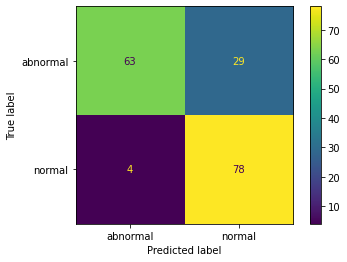

In [16]:
from tensorflow import concat, argmax
def predict_and_plot_confussion_matrix(model, test_ds):
  y_pred = model.predict(test_ds)
  pred_categories = y_pred.round()
  true_categories = concat([y for x, y in test_ds], axis=0)

  fig, ax = plt.subplots()
  cm = confusion_matrix(true_categories, pred_categories)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=["abnormal", "normal"])
  disp.plot(ax=ax)
  plt.show()

predict_and_plot_confussion_matrix(model, test_ds)

In [17]:
#Function to compute several models changing Optimizers and learning rate
def compute(model, train_ds, valid_ds):
  rates = [0.001, 0.01, 0.1]
  optimizers = []
  result = []
  for r in range(len(rates)):
    optimizers.append([SGD(learning_rate=rates[r]), "SGD", rates[r]])
    optimizers.append([Adadelta(learning_rate=rates[r]), "Adadelta", rates[r]])
    optimizers.append([Adagrad(learning_rate=rates[r]), "Adagrad", rates[r]])
    optimizers.append([Adam(learning_rate=rates[r]), "Adam", rates[r]])
 
  for i in range(len(optimizers)):
    optimizer = optimizers[i]
    # Not sure if this helps reseting the model
    model = build_model()
    model.compile(
        optimizer=optimizer[0], 
        loss=keras.losses.BinaryCrossentropy(from_logits=False), 
        metrics=[keras.metrics.BinaryAccuracy()]
    )    
    t0 = timeit.default_timer()
    history = model.fit(train_ds, epochs=20, batch_size=64, verbose=1,
                        validation_data=valid_ds)
    training_time = timeit.default_timer() - t0
    avg_accuracy = np.mean(history.history['val_binary_accuracy'])
    result.append([optimizer[1], optimizer[2], training_time, avg_accuracy])
  return result

In [18]:
#Compute models
c = compute(model, train_ds, valid_ds)

Epoch 1/20
44/44 [==============================] - 9s 84ms/step - loss: 0.7318 - binary_accuracy: 0.5794 - val_loss: 0.6392 - val_binary_accuracy: 0.6299
Epoch 2/20
44/44 [==============================] - 3s 55ms/step - loss: 0.6498 - binary_accuracy: 0.6664 - val_loss: 0.6032 - val_binary_accuracy: 0.7403
Epoch 3/20
44/44 [==============================] - 3s 55ms/step - loss: 0.6101 - binary_accuracy: 0.6954 - val_loss: 0.5770 - val_binary_accuracy: 0.7727
Epoch 4/20
44/44 [==============================] - 3s 55ms/step - loss: 0.5942 - binary_accuracy: 0.7049 - val_loss: 0.5534 - val_binary_accuracy: 0.7792
Epoch 5/20
44/44 [==============================] - 3s 55ms/step - loss: 0.5766 - binary_accuracy: 0.7114 - val_loss: 0.5336 - val_binary_accuracy: 0.7792
Epoch 6/20
44/44 [==============================] - 3s 55ms/step - loss: 0.5404 - binary_accuracy: 0.7368 - val_loss: 0.5183 - val_binary_accuracy: 0.7727
Epoch 7/20
44/44 [==============================] - 3s 55ms/step - los

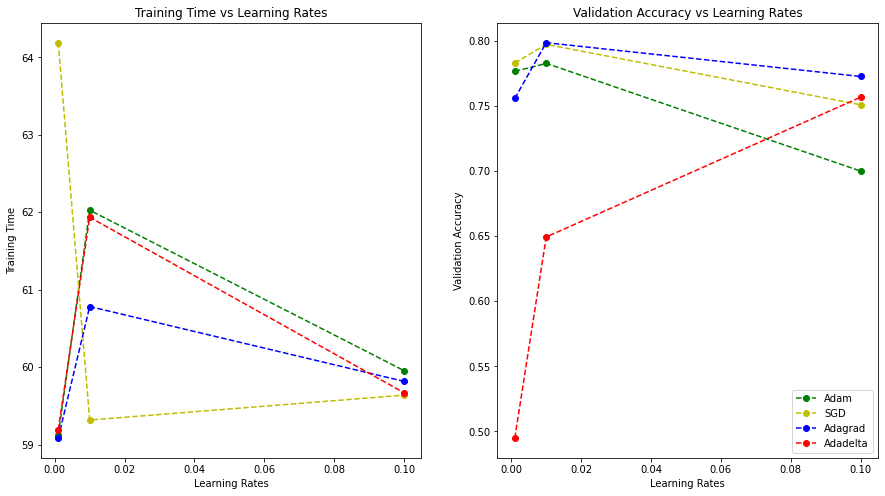

In [19]:
#Plots

# distribuir el resultado en variables más legibles
opts = []
times = []
rates = []
acc = []
for i in range(len(c)):
  m = c[i]
  opts.append(m[0])
  rates.append(m[1])
  times.append(m[2]) 
  acc.append(m[3])

# Variables para las coordenadas de las lineas
adam_rates = []
adam_accuracy = []
adam_times = []
sgd_rates = []
sgd_accuracy = []
sgd_times = []
adagrad_rates = []
adagrad_accuracy = []
adagrad_times = []
adadelta_rates = []
adadelta_accuracy = []
adadelta_times = []

# Transformacion de variables
for i in range(len(times)):
  if opts[i] == 'Adam':
    adam_rates.append(rates[i])
    adam_times.append(times[i])
    adam_accuracy.append(acc[i])
  elif opts[i] == 'SGD':
    sgd_rates.append(rates[i])
    sgd_times.append(times[i])
    sgd_accuracy.append(acc[i])
  elif opts[i] == 'Adagrad':
    adagrad_rates.append(rates[i])
    adagrad_times.append(times[i])
    adagrad_accuracy.append(acc[i])
  elif opts[i] == 'Adadelta':
    adadelta_rates.append(rates[i])
    adadelta_times.append(times[i]) 
    adadelta_accuracy.append(acc[i])

fig, ax = plt.subplots(1,2, figsize=(15,8))

ax[0].plot(adam_rates, adam_times, linestyle='--', marker='o', color='g', label='Adam')
ax[0].plot(sgd_rates, sgd_times, linestyle='--', marker='o', color='y', label='SGD')
ax[0].plot(adagrad_rates, adagrad_times, linestyle='--', marker='o', color='b', label='Adagrad')
ax[0].plot(adadelta_rates, adadelta_times, linestyle='--', marker='o', color='r', label='Adadelta')
ax[0].set_title('Training Time vs Learning Rates')
ax[0].set_xlabel('Learning Rates')
ax[0].set_ylabel('Training Time')

ax[1].plot(adam_rates, adam_accuracy, linestyle='--', marker='o', color='g', label='Adam')
ax[1].plot(sgd_rates, sgd_accuracy, linestyle='--', marker='o', color='y', label='SGD')
ax[1].plot(adagrad_rates, adagrad_accuracy, linestyle='--', marker='o', color='b', label='Adagrad')
ax[1].plot(adadelta_rates, adadelta_accuracy, linestyle='--', marker='o', color='r', label='Adadelta')
ax[1].set_title('Validation Accuracy vs Learning Rates')
ax[1].set_xlabel('Learning Rates')
ax[1].set_ylabel('Validation Accuracy')
plt.legend()
plt.show()

De los gráficos anteriores, utilizaremos el optimizador SGD con un learning rate de 0.05 dado que, junto con Adagrad, presenta los mejores resultados y tiene un menor tiempo de entrenamiento. Ahora, buscamos número óptimo de épocas con el optimizador seleccionado.

In [20]:
# Plot del training loss y el accuracy
def plot_loss_accuracy(n_epochs, mfit):
  loss = mfit.history['loss']
  val_loss = mfit.history['val_loss']

  accuracy = mfit.history['binary_accuracy']
  val_accuracy = mfit.history['val_binary_accuracy']

  epochs = range(0,n_epochs)
  plt.subplots(figsize=(15,10))
  plt.plot(epochs, loss, 'g', label='Training Loss')
  plt.plot(epochs, val_loss, 'y', label='Validation Loss')

  plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
  plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')

  plt.title('Model Loss and Accuracy')
  plt.xticks(epochs)
  plt.xlabel('Epochs')
  plt.ylabel('Total')
  plt.legend()
  plt.show()

In [21]:
# As result of previous trainings
LEARNING_RATE = 0.001

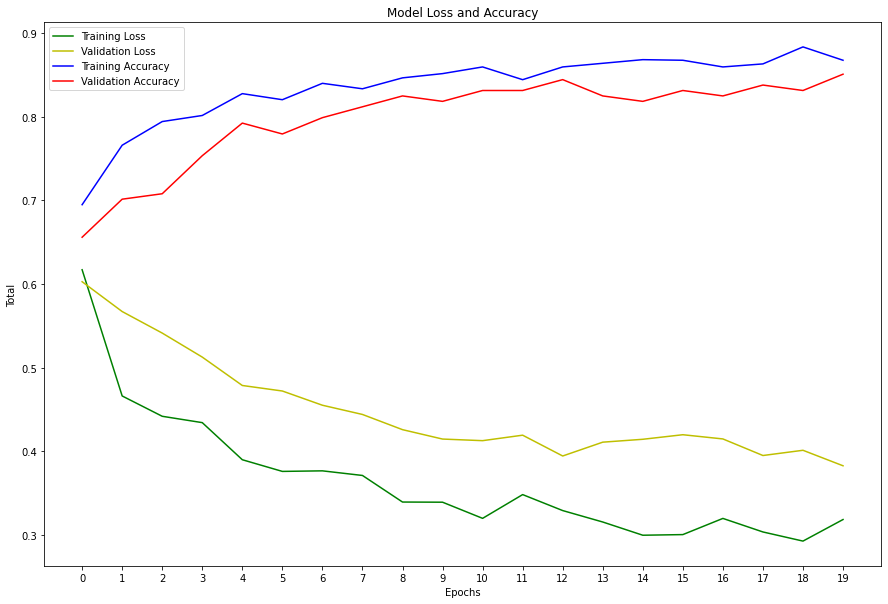

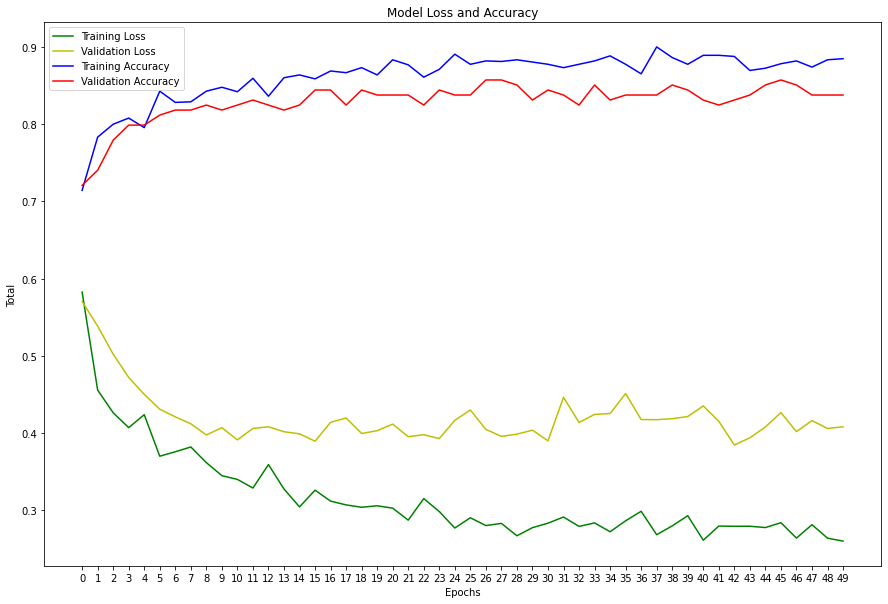

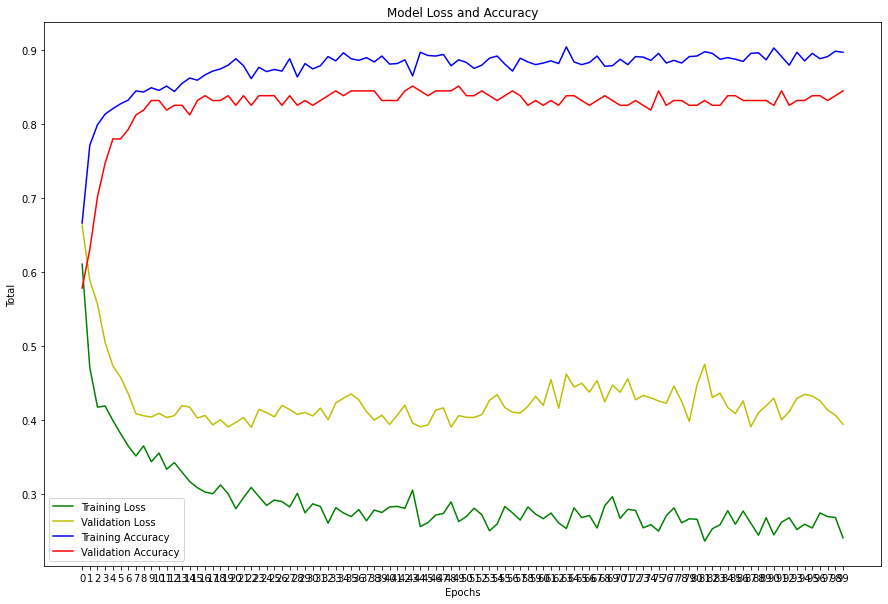

In [22]:
#Function to compute several models changing epochs
def compute_epochs(train_ds, valid_ds):
  epochs = [20, 50, 100]
 
  for i in range(len(epochs)):
    # Not sure if this helps reseting the model
    model = build_model()
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE), 
        loss=keras.losses.BinaryCrossentropy(from_logits=False), 
        metrics=[keras.metrics.BinaryAccuracy()]
    )      
    t0 = timeit.default_timer()
    history = model.fit(train_ds, epochs=epochs[i], batch_size=64, verbose=0,
                        validation_data=valid_ds)
    training_time = timeit.default_timer() - t0
    plot_loss_accuracy(epochs[i], history)
    avg_accuracy = np.mean(history.history['val_binary_accuracy'])

compute_epochs(train_ds, valid_ds)

En este momento tenemos claros las épocos y los hyperparámetros a utilizar para el modelo 1. Lo preparamos de cero y generamos sus resultados.

In [23]:
# As result of previous trainings
EPOCHS = 50

Epoch 1/50
44/44 [==============================] - 10s 83ms/step - loss: 0.5745 - binary_accuracy: 0.7136 - val_loss: 0.5863 - val_binary_accuracy: 0.6818
Epoch 2/50
44/44 [==============================] - 3s 55ms/step - loss: 0.4713 - binary_accuracy: 0.7796 - val_loss: 0.5667 - val_binary_accuracy: 0.7013
Epoch 3/50
44/44 [==============================] - 3s 54ms/step - loss: 0.4189 - binary_accuracy: 0.8100 - val_loss: 0.5311 - val_binary_accuracy: 0.7468
Epoch 4/50
44/44 [==============================] - 3s 55ms/step - loss: 0.4162 - binary_accuracy: 0.8144 - val_loss: 0.5072 - val_binary_accuracy: 0.7727
Epoch 5/50
44/44 [==============================] - 3s 55ms/step - loss: 0.3851 - binary_accuracy: 0.8310 - val_loss: 0.4925 - val_binary_accuracy: 0.7597
Epoch 6/50
44/44 [==============================] - 3s 55ms/step - loss: 0.3865 - binary_accuracy: 0.8260 - val_loss: 0.4523 - val_binary_accuracy: 0.8052
Epoch 7/50
44/44 [==============================] - 3s 55ms/step - lo

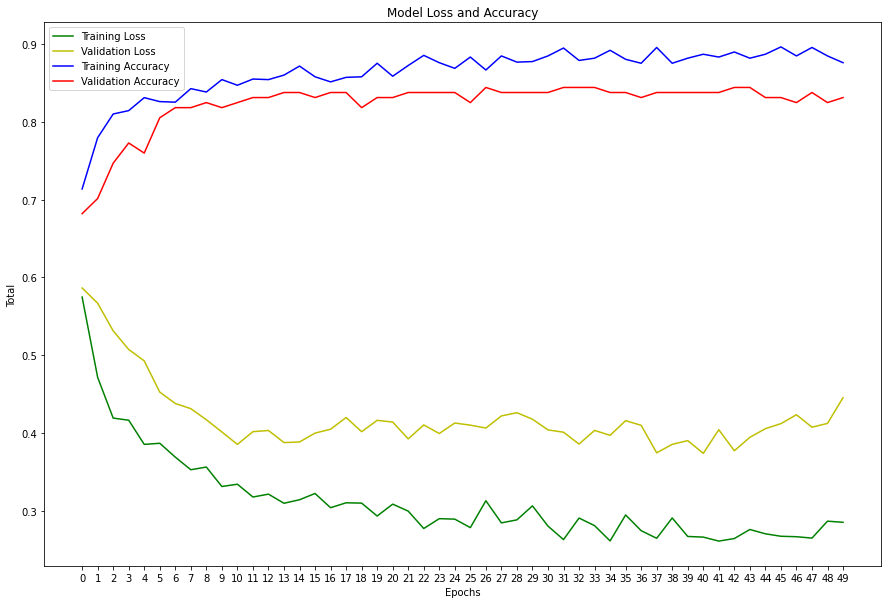

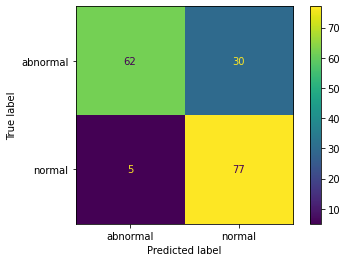

In [24]:
model_top_layer = build_model()
# Compile
model_top_layer.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), 
    loss=keras.losses.BinaryCrossentropy(from_logits=False), 
    metrics=[keras.metrics.BinaryAccuracy()]
)

# Entrenar el modelo
t0 = timeit.default_timer()
history = model_top_layer.fit(train_ds, epochs=EPOCHS, batch_size=32, validation_data=valid_ds, verbose=1)
training_time_ann = timeit.default_timer() - t0
plot_loss_accuracy(EPOCHS, history)

predict_and_plot_confussion_matrix(model_top_layer, test_ds)

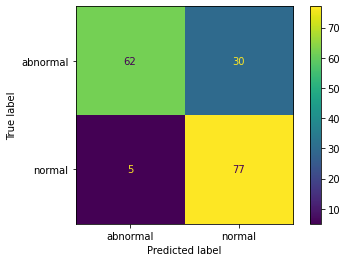

In [25]:
predict_and_plot_confussion_matrix(model_top_layer, test_ds)

En la siguiente sección crearemos un modelo a partir de la arquitectura previa y mismas épocas e hiperparámetros pero marcaremos como entrebales las últimas 20 capas. En realidad, de las últimas 20 (incluyendo el output), aquellas que no sean de tipo `BatchNormalization`

In [26]:
def unfreeze_layers(model, nlayers):

  model_layers = len(model.layers)
  if nlayers >= model_layers:
    model.trainable = True
  else:
    unfreeze(model, nlayers)

  return model

def unfreeze(model, nlayers):

  model_layers = len(model.layers)
  for i in range(1,nlayers +1):
    layer = model.get_layer(index=(model_layers - i))
    if isinstance(layer,layers.BatchNormalization):
      layer.trainable = False
    else:
      layer.trainable = True
  return model

model_20 = build_model()
model_20 = unfreeze_layers(model, 20)
model_20.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                     

In [27]:
for layer in model_20.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7ff2c2fefe50> False
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7ff2c2716590> False
<keras.layers.preprocessing.normalization.Normalization object at 0x7ff2bf739f10> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7ff2bf739fd0> False
<keras.layers.convolutional.Conv2D object at 0x7ff2b0074dd0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff24456f990> False
<keras.layers.core.activation.Activation object at 0x7ff24456f910> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7ff2bf808e90> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff244531d50> False
<keras.layers.core.activation.Activation object at 0x7ff2ddbfb550> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7ff24456fe50> False
<keras.layers.core.reshape.Reshape object at 0x7ff244564210> False
<keras.layers.convolutional.Conv2D object at 0x7

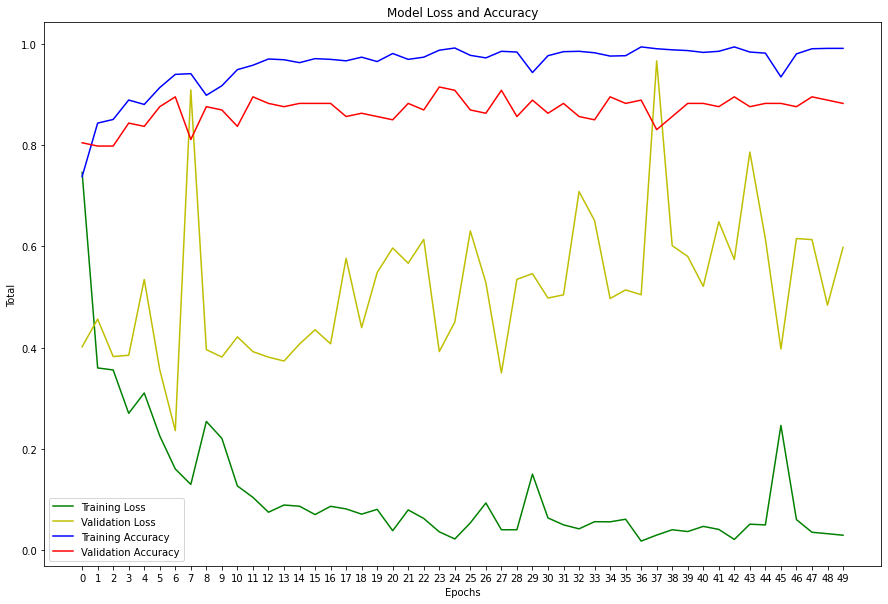

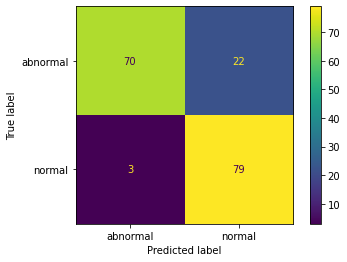

In [28]:
# Compile
model_20.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), 
    loss=keras.losses.BinaryCrossentropy(from_logits=False), 
    metrics=[keras.metrics.BinaryAccuracy()]
)

# Entrenar el modelo
t0 = timeit.default_timer()
history = model_20.fit(train_ds, epochs=EPOCHS, batch_size=32, validation_data=valid_ds, verbose=0)
training_time_ann = timeit.default_timer() - t0

plot_loss_accuracy(EPOCHS, history)
predict_and_plot_confussion_matrix(model_20, test_ds)

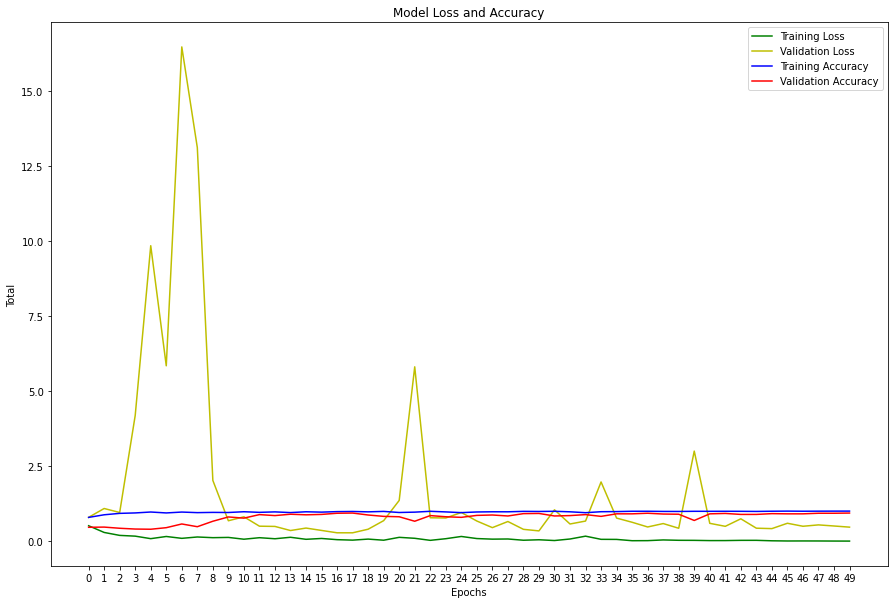

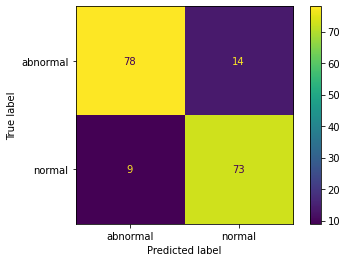

In [29]:
model_full = build_model()
model_full.trainable = True

# Compile
model_full.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), 
    loss=keras.losses.BinaryCrossentropy(from_logits=False), 
    metrics=[keras.metrics.BinaryAccuracy()]
)

# Entrenar el modelo
t0 = timeit.default_timer()
history = model_full.fit(train_ds, epochs=EPOCHS, batch_size=32, validation_data=valid_ds, verbose=0)
training_time_ann = timeit.default_timer() - t0
plot_loss_accuracy(EPOCHS, history)
predict_and_plot_confussion_matrix(model_full, test_ds)

# Sección 3. Validación cruzada y discusión (3 puntos)

In [30]:
def load_dataset(folder, model, suffle):
  data_dir = os.path.join(folder, model)
  batch_size=32
  dataset = image_dataset_from_directory(
    data_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    label_mode='binary',
    class_names=CLASS_NAMES,
    shuffle=suffle)
  return dataset

In [50]:
def load_model_arrays(folder):
  train, test, valid = load_models(folder)

  X_train = train[:,0]
  y_train = train[:,1]

  X_test = test[:,0]
  y_test = test[:,1]

  # Change dimensions for proper model fit processing
  X_train = np.array([np.array(val) for val in X_train])
  y_train = np.array([np.array(val) for val in y_train])

  X_test = np.array([np.array(val) for val in X_test])
  y_test = np.array([np.array(val) for val in y_test])

  # Convert string categories to 0-1 values (0: abnormal, 1: normal)
  y_train = y_train == 'normal'
  y_train = y_train.astype(int)

  y_test = y_test == 'normal'
  y_test = y_test.astype(int)

  return X_train, y_train, X_test, y_test

In [ ]:
X_train_0, y_train_0, X_test_0, y_test_0 = load_model_arrays('Fold0')
X_train_1, y_train_1, X_test_1, y_test_1 = load_model_arrays('Fold1')
X_train_2, y_train_2, X_test_2, y_test_2 = load_model_arrays('Fold2')
X_train_3, y_train_3, X_test_3, y_test_3 = load_model_arrays('Fold3')
X_train_4, y_train_4, X_test_4, y_test_4 = load_model_arrays('Fold4')
X_train_5, y_train_5, X_test_5, y_test_5 = load_model_arrays('Fold5')
X_train_6, y_train_6, X_test_6, y_test_6 = load_model_arrays('Fold6')
X_train_7, y_train_7, X_test_7, y_test_7 = load_model_arrays('Fold7')
X_train_8, y_train_8, X_test_8, y_test_8 = load_model_arrays('Fold8')
X_train_9, y_train_9, X_test_9, y_test_9 = load_model_arrays('Fold9')


In [63]:
# Ejemplo de f1 score
from sklearn.metrics import f1_score
y_pred = model_full.predict(X_test_0)

print(f1_score(y_test_0, y_pred.round()))

0.9146341463414634


In [68]:
cvscores = []

def process_evaluate(model, X_train, y_train, X_test, y_test):

  t0 = timeit.default_timer()
  history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, verbose=0)
  training_time_ann = timeit.default_timer() - t0

  y_pred = model_full.predict(X_test)

  return f1_score(y_test, y_pred.round())

scores = process_evaluate(model_full, X_train_0, y_train_0, X_test_0, y_test_0)
cvscores.append(scores * 100)
scores = process_evaluate(model_full, X_train_1, y_train_1, X_test_1, y_test_1)
cvscores.append(scores * 100)
scores = process_evaluate(model_full, X_train_2, y_train_2, X_test_2, y_test_2)
cvscores.append(scores * 100)
scores = process_evaluate(model_full, X_train_3, y_train_3, X_test_3, y_test_3)
cvscores.append(scores * 100)
scores = process_evaluate(model_full, X_train_4, y_train_4, X_test_4, y_test_4)
cvscores.append(scores * 100)
scores = process_evaluate(model_full, X_train_5, y_train_5, X_test_5, y_test_5)
cvscores.append(scores * 100)
scores = process_evaluate(model_full, X_train_6, y_train_6, X_test_6, y_test_6)
cvscores.append(scores * 100)
scores = process_evaluate(model_full, X_train_7, y_train_7, X_test_7, y_test_7)
cvscores.append(scores * 100)
scores = process_evaluate(model_full, X_train_8, y_train_8, X_test_8, y_test_8)
cvscores.append(scores * 100)
scores = process_evaluate(model_full, X_train_9, y_train_9, X_test_9, y_test_9)
cvscores.append(scores * 100)

85.26% (+/- 2.19%)


In [71]:
print(cvscores)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

[88.13559322033899, 85.1063829787234, 86.06060606060606, 83.42245989304811, 84.15300546448087, 80.43478260869564, 86.3905325443787, 84.32432432432432, 87.86127167630057, 86.70520231213872]
85.26% (+/- 2.19%)
